In [10]:
from deeplab3.dataloaders import make_data_loader
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import torch

import json
import datetime

import model_utils

Visualize Darkening Effect
----

In [2]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/coco_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/coco/'])

In [3]:
dataloaders = make_data_loader(cfg)

loading annotations into memory...
Done (t=14.64s)
creating index...
index created!
Using RGB-D input
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Using RGB-D input


Text(0.5, 1.0, 'Original')

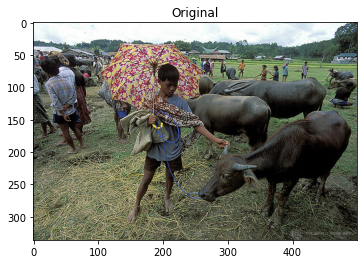

In [4]:
dataset = dataloaders[0].dataset
img_path, depth_path, label_path = dataset.coco_paths(2)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original")

### Different Darkening Degrees

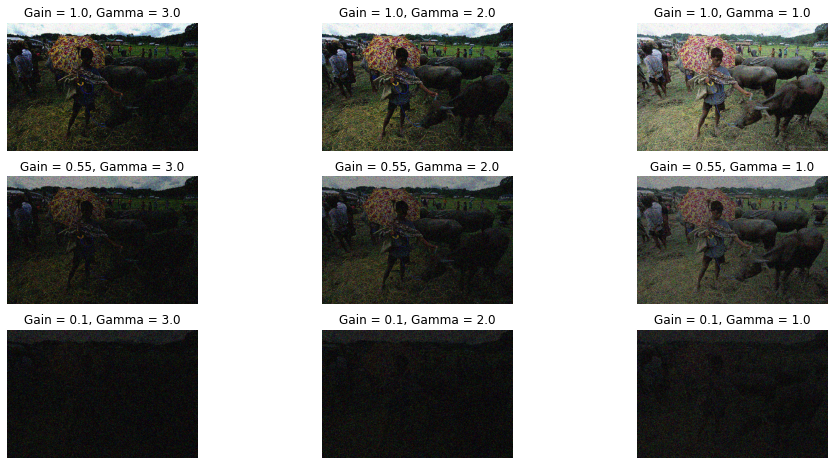

In [5]:
gain = np.linspace(0.1, 1, 3).tolist()
gain.reverse()
gamma = np.linspace(1,3, 3).tolist()
gamma.reverse()

plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        
        index += 1

### RE-Brightened to visualize noise

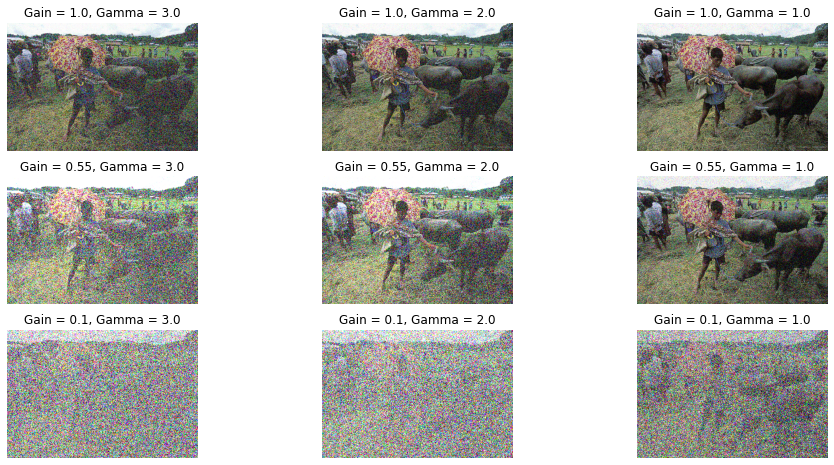

In [6]:
plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        index += 1

## Network Performance

In [7]:
model_configs = model_utils.get_all_models("../run/")
len(model_configs)

100

In [27]:
low_light_models = [ \
                    #Bright models 
                   '../run/older/cityscapes_rgbd_xception_fine/2020_04_26-20_04_07/parameters.txt.yaml',
                   '../run/older/cityscapes_rgb_xception_pt/2020_04_27-01_43_58/parameters.txt.yaml',
                    '../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml',
                   '../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml',
                    #Low-light models
                   '../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml']

In [28]:
failed = []

metric_dict = {'RGB': { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}} ,
               'RGBD' : { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}}}

for index, cfg_filepath in enumerate(low_light_models):
    try:
        print(cfg_filepath)
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                             'MODEL.PRETRAINED', "",
                             'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        for i in gain:
            print("Gain {}".format(i))
            
            for j in gamma:
                print("Gamma {}".format(j))
                
                low = "low-light" if index>3 else "normal"
                print(low)
                
                cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                    'DATASET.DARKEN.GAIN', float(i),
                                    'DATASET.DARKEN.GAMMA', float(j)])
        
                model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
                checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))
                
                result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'validation_report3_gain{:3.2f}_gamma{:3.2f}.txt'.format(float(i), float(j)))
                checkpoint_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'checkpoint.pth.tar')
                if os.path.exists(result_file) and (os.path.getmtime(result_file) > os.path.getmtime(checkpoint_file)):
                    with open(result_file, 'r') as fp:
                        metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                        metrics = json.loads('{' + metric_str + '}')
                    print("Success on {} {} {} {} {}".format(cfg.DATASET.MODE, low, cfg.DATASET.NAME, i, j))
                else:
                    metrics = {'mIoU': 0}
                    print("Failed to load {}".format(result_file))
                    #metrics = model_utils.test_model(cfg, result_file)

                metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME][i][j] = metrics['mIoU']
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)
        

../run/older/cityscapes_rgbd_xception_fine/2020_04_26-20_04_07/parameters.txt.yaml
Non-existent key: TRAIN.LR_SCHEDULER
Non-existent key: TRAIN.MOMENTUM
Non-existent key: TRAIN.NESTROV
Non-existent key: TRAIN.WEIGHT_DECAY
Gain 1.0
Gamma 3.0
normal
Success on RGBD normal cityscapes 1.0 3.0
Gamma 2.0
normal
Success on RGBD normal cityscapes 1.0 2.0
Gamma 1.0
normal
Success on RGBD normal cityscapes 1.0 1.0
Gain 0.55
Gamma 3.0
normal
Success on RGBD normal cityscapes 0.55 3.0
Gamma 2.0
normal
Success on RGBD normal cityscapes 0.55 2.0
Gamma 1.0
normal
Success on RGBD normal cityscapes 0.55 1.0
Gain 0.1
Gamma 3.0
normal
Success on RGBD normal cityscapes 0.1 3.0
Gamma 2.0
normal
Success on RGBD normal cityscapes 0.1 2.0
Gamma 1.0
normal
Success on RGBD normal cityscapes 0.1 1.0
../run/older/cityscapes_rgb_xception_pt/2020_04_27-01_43_58/parameters.txt.yaml
Non-existent key: TRAIN.LR_SCHEDULER
Non-existent key: TRAIN.MOMENTUM
Non-existent key: TRAIN.NESTROV
Non-existent key: TRAIN.WEIGHT_DEC

In [29]:
metric_dict

{'RGB': {'low-light': {'scenenet': {1.0: {3.0: 0.3148603648091553,
     2.0: 0.3348955849174914,
     1.0: 0.31767128790566584},
    0.55: {3.0: 0.2943759031439823,
     2.0: 0.32287452058198296,
     1.0: 0.3287878596583716},
    0.1: {3.0: 0.13558650819952187,
     2.0: 0.15716282618521835,
     1.0: 0.16029063746959485}},
   'cityscapes': {1.0: {3.0: 0.3282260905360265,
     2.0: 0.4025237432812318,
     1.0: 0.4270172029326755},
    0.55: {3.0: 0.2843712257051201,
     2.0: 0.36831287026390047,
     1.0: 0.41753605575125846},
    0.1: {3.0: 0.12963322495761373,
     2.0: 0.16894987356415406,
     1.0: 0.20392181198553122}}},
  'normal': {'scenenet': {1.0: {3.0: 0.17518353706883047,
     2.0: 0.20502510749801048,
     1.0: 0.20092040326476823},
    0.55: {3.0: 0.10691424715328693,
     2.0: 0.1466088604872478,
     1.0: 0.16230231274624327},
    0.1: {3.0: 0.006661065903349312,
     2.0: 0.006581669410833206,
     1.0: 0.006848436042009075}},
   'cityscapes': {1.0: {3.0: 0.024529394

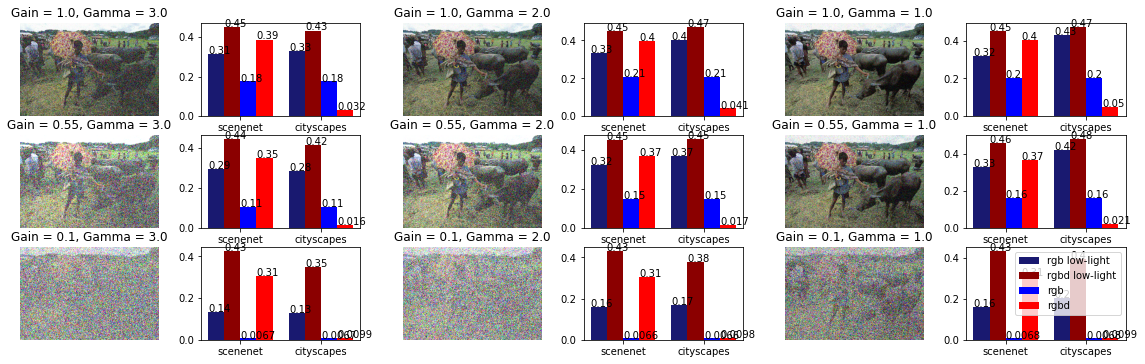

In [30]:
plt.figure(figsize=(20, 12))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain)*2, len(gamma)*2, index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        index += 1
        
        labels = ['scenenet', 'cityscapes']
                
        y_pos = np.arange(2)
        width = 0.20
        
        ax1 = plt.subplot(len(gain)*2, len(gamma)*2, index)
        ax1.bar(y_pos - 2*width, [metric_dict['RGB']['low-light']['scenenet'][i][j], 
                                 metric_dict['RGB']['low-light']['cityscapes'][i][j]], 
                width=width, color='midnightblue', label="rgb low-light")
        ax1.bar(y_pos - width, [metric_dict['RGBD']['low-light']['scenenet'][i][j], 
                                metric_dict['RGBD']['low-light']['cityscapes'][i][j]], 
                width=width, color='darkred', label="rgbd low-light")
        ax1.bar(y_pos, [metric_dict['RGB']['normal']['scenenet'][i][j], 
                        metric_dict['RGB']['normal']['scenenet'][i][j]], 
                width=width, color='blue', label="rgb")
        ax1.bar(y_pos + width, [metric_dict['RGBD']['normal']['scenenet'][i][j], 
                                metric_dict['RGBD']['normal']['cityscapes'][i][j]],
                width=width, color='red', label="rgbd")
    
        ax1.set_xticks(y_pos - 0.1)
        ax1.set_xticklabels(labels)
        
        for p in ax1.patches:
            if p.get_height() > 0 :
                ax1.annotate("{:3.2}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
            
        index += 1
        
ax1.legend()